In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# from desc import set_device
# set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

In [3]:
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.continuation import solve_continuation_automatic

print_backend_info()

DESC version=0.16.0+47.g7f2fb8c32.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: CPU, with 19.20 GB available memory.


# About this Notebook

I will create coils with the properties based on Jeff's specifications. The related information from the emails are given in the cells for reference. The initial coils are from Rahul's paper, they won't be used for the optimization.

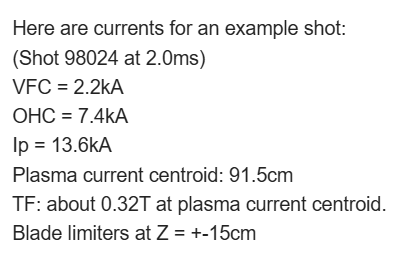

In [4]:
coils = load("Rahul-Scripts/beak_beta1p0_coilset_reversed_current4.h5")

In [5]:
# plot coils in different colors to see which is which
fig = plot_coils(coils.coils[0], color="red")
fig = plot_coils(coils.coils[1], color="black", fig=fig)
fig = plot_coils(coils.coils[2], color="green", fig=fig)
fig = plot_coils(coils.coils[3], color="blue", fig=fig)
fig = plot_coils(coils.coils[4], color="yellow", fig=fig)
fig = plot_coils(coils.coils[5], color="magenta", fig=fig)
fig

In [6]:
# give some descriptive names
coils.coils[0].name = "Big upper PF coil"
coils.coils[1].name = "Big lower PF coil"
coils.coils[4].name = "Small upper PF coil"
coils.coils[5].name = "Small lower PF coil"
coils.coils[2].name = "TF coilset"
coils.coils[2].coils[0].name = "TF coil"

# TF Coils

Each individual TF magnet is 64 turns in a 32x2 double-pancake.  The cross-sectional area of the turns is 6"x1" (15.2cm x 2.5cm), giving a radial thickness of ~0.15m.  Average radius of this cross-section for a single filament approximation is 17.4" = ~0.44m.

In [16]:
from scipy.constants import mu_0
n_coils = 20
# B_center = mu_0 N I / (2pi r)
# I = B_center * (2pi r) / (mu_0 N)
# Given data of B = 0.32 T at R = 91.5 cm
I = 2 * np.pi * 0.915 * 0.32 / (mu_0 * n_coils)
tf_coils = FourierPlanarCoil(
    current=I, center=[0.9716, 0, 0], normal=[0, 1, 0], r_n=0.44196, name="TF coil"
)
tf_coils = CoilSet(tf_coils, NFP=n_coils, name="TF coilset", check_intersection=False)
print("TF Coil Current", tf_coils.coils[0].current)
B0 = tf_coils.compute_magnetic_field([0.915, 0, 0], basis="rpz")
print("B at 91.5 cm radius: ", B0)

TF Coil Current 73200.0000096648
B at 91.5 cm radius:  [[-0.      0.3202  0.    ]]


# VF Coils (Outer)

All VF coil turns listed below are wired in series, so the current is the same in each turn.

These 4 turns are mirrored below the midplane. Current is in the -phi direction for each turn. The IDL code presently treats these 4 turns as 1 turn with 4 times the current, hence the 4 identical IDL rows above.  These outermost coils produce a field that points downward in the lab frame.

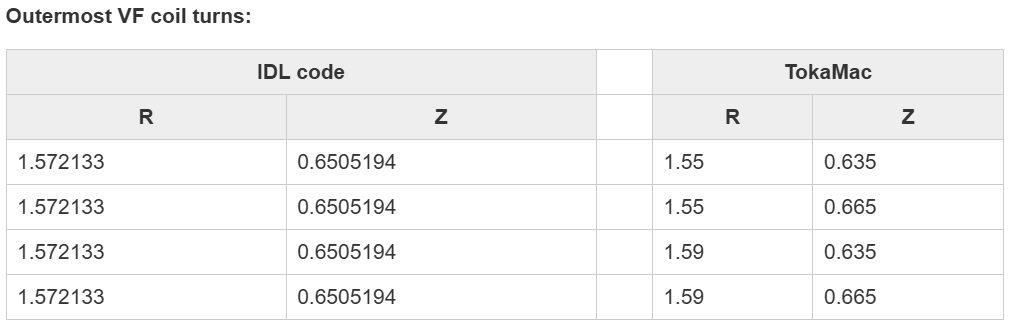

In [15]:
vf_ou1 = FourierPlanarCoil(
    current=-2200 * 4,
    center=[0, 0, 0.6505194],
    normal=[0, 0, 1],
    r_n=1.572133,
    name="Outer VF coil",
)
vf_ol1 = FourierPlanarCoil(
    current=-2200 * 4,
    center=[0, 0, -0.6505194],
    normal=[0, 0, 1],
    r_n=1.572133,
    name="Outer VF coil",
)
vf_outer_list = [vf_ou1, vf_ol1]
B0 = vf_ou1.compute_magnetic_field([0, 0, 0.6505194], basis="rpz")
print("B at Z=65cm: ", B0)

B at Z=65cm:  [[ 0.      0.     -0.0035]]


# VF Coils (Inner)

These 6 turns are mirrored below the midplane. Current is in the +phi direction for each turn.

The IDL specifications above agree with the OH transformer coil design drawings.

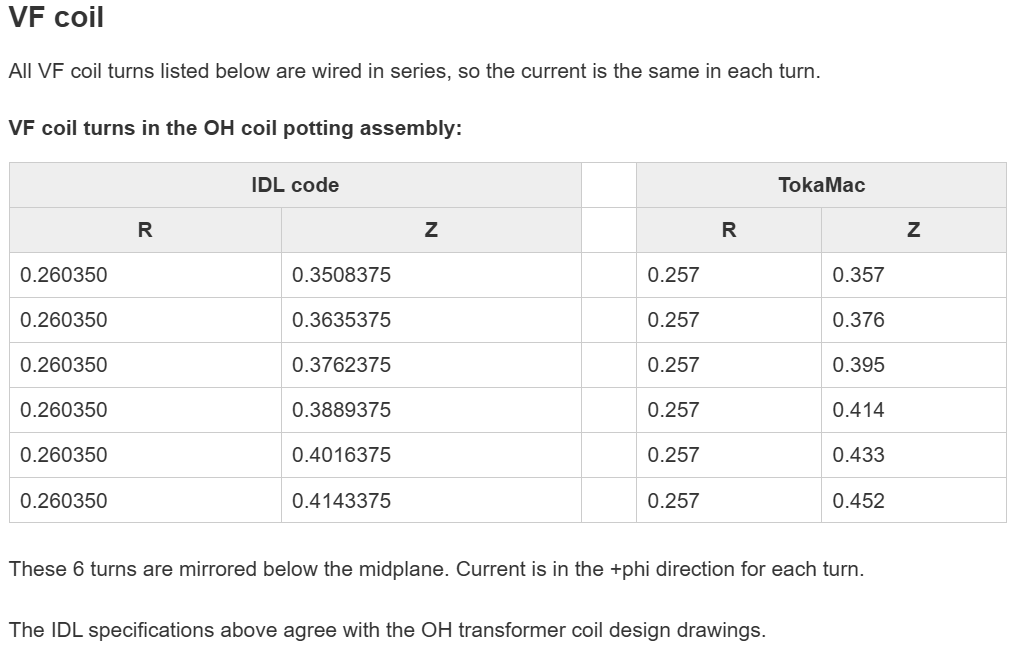

In [14]:
vf_iu1 = FourierPlanarCoil(
    current=2200,
    center=[0, 0, 0.3508375],
    normal=[0, 0, 1],
    r_n=0.260350,
    name="Inner VF coil",
)
vf_il1 = FourierPlanarCoil(
    current=2200,
    center=[0, 0, -0.3508375],
    normal=[0, 0, 1],
    r_n=0.260350,
    name="Inner VF coil",
)
vf_inner_list = []
z_positions = [0.3508375, 0.3635375, 0.3762375, 0.3889375, 0.4016375, 0.4143375]
for z_pos in z_positions:
    c_upper = vf_iu1.copy()
    c_lower = vf_il1.copy()
    c_upper.center = jnp.array([0.0, 0.0, z_pos])
    c_lower.center = jnp.array([0.0, 0.0, -z_pos])
    vf_inner_list.append(c_upper)
    vf_inner_list.append(c_lower)

B0 = vf_iu1.compute_magnetic_field([0, 0, 0.3508375], basis="rpz")
print("B at Z=35cm: ", B0)

B at Z=35cm:  [[0.     0.     0.0053]]


# OH Coils (inner)

OH coil turns in the OH coil potting assembly:

These 4 turns are mirrored below the midplane. Current is in the -phi direction for each turn.

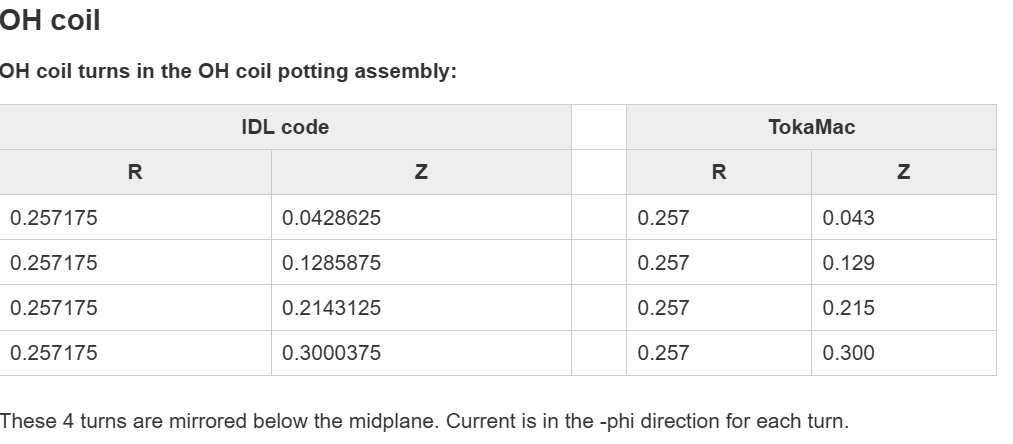

In [17]:
oh_iu1 = FourierPlanarCoil(
    current=-7400,
    center=[0, 0, 0.0428625],
    normal=[0, 0, 1],
    r_n=0.257175,
    name="Inner OH coil",
)
oh_il1 = FourierPlanarCoil(
    current=-7400,
    center=[0, 0, -0.0428625],
    normal=[0, 0, 1],
    r_n=0.257175,
    name="Inner OH coil",
)

oh_inner_list = []
z_positions = [0.0428625, 0.1285875, 0.2143125, 0.3000375]
for z_pos in z_positions:
    c_upper = oh_iu1.copy()
    c_lower = oh_il1.copy()
    c_upper.center = jnp.array([0.0, 0.0, z_pos])
    c_lower.center = jnp.array([0.0, 0.0, -z_pos])
    oh_inner_list.append(c_upper)
    oh_inner_list.append(c_lower)

B0 = oh_iu1.compute_magnetic_field([0, 0, 0.0428625], basis="rpz")
print("B at Z=4cm: ", B0)

B at Z=4cm:  [[ 0.      0.     -0.0181]]


# OH Coils (outer)

Outer OH coil turns (Above the TF magnet 45 degree corner):

These 2 turns are mirrored below the midplane. Current is in the -phi direction for each turn.

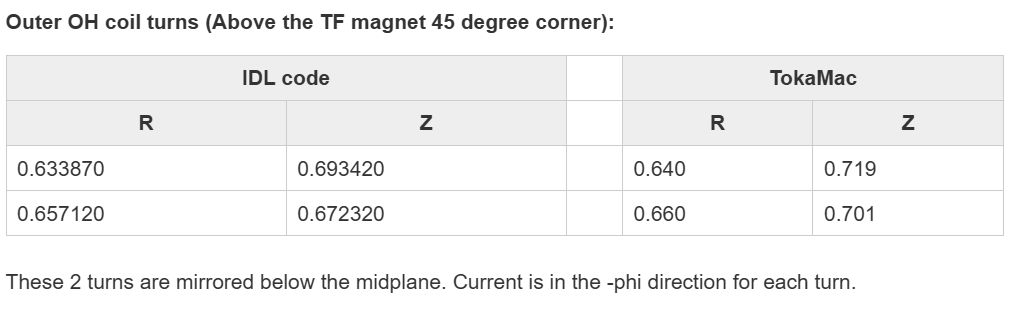

In [18]:
oh_ou1 = FourierPlanarCoil(
    current=-7400,
    center=[0, 0, 0.693420],
    normal=[0, 0, 1],
    r_n=0.633870,
    name="Outer OH coil",
)
oh_ol1 = FourierPlanarCoil(
    current=-7400,
    center=[0, 0, -0.693420],
    normal=[0, 0, 1],
    r_n=0.633870,
    name="Outer OH coil",
)
oh_ou2 = FourierPlanarCoil(
    current=-7400,
    center=[0, 0, 0.672320],
    normal=[0, 0, 1],
    r_n=0.657120,
    name="Outer OH coil",
)
oh_ol2 = FourierPlanarCoil(
    current=-7400,
    center=[0, 0, -0.672320],
    normal=[0, 0, 1],
    r_n=0.657120,
    name="Outer OH coil",
)

oh_outer_list = [oh_ou1, oh_ol1, oh_ou2, oh_ol2]
B0 = oh_ou1.compute_magnetic_field([0, 0, 0.693420], basis="rpz")
print("B at Z=69cm: ", B0)

B at Z=69cm:  [[ 0.      0.     -0.0073]]


# Form `MixedCoilset()`

In [19]:
vf_outer_coilset = CoilSet(
    *vf_outer_list, name="Outer VF coilset", check_intersection=False
)
vf_inner_coilset = CoilSet(
    *vf_inner_list, name="Inner VF coilset", check_intersection=False
)
oh_inner_coilset = CoilSet(
    *oh_inner_list, name="Inner OH coilset", check_intersection=False
)
oh_outer_coilset = CoilSet(
    *oh_outer_list, name="Outer OH coilset", check_intersection=False
)

In [20]:
default_coils = MixedCoilSet(
    [
        # TF coils as coilset
        tf_coils,
        # outer VF coils
        vf_outer_coilset,
        # inner VF coils
        vf_inner_coilset,
        # OH coils
        oh_inner_coilset,
        oh_outer_coilset,
    ],
    name="HBT default coils",
    check_intersection=False,
)
default_coils.save("hbt_default_coils.h5")

In [21]:
fig = plot_coils(default_coils)
fig.write_html("hbt_default_coils.html")
fig

# Get `SplineMagneticField` for fast evaluation

Fit the field inside the red rectangle.

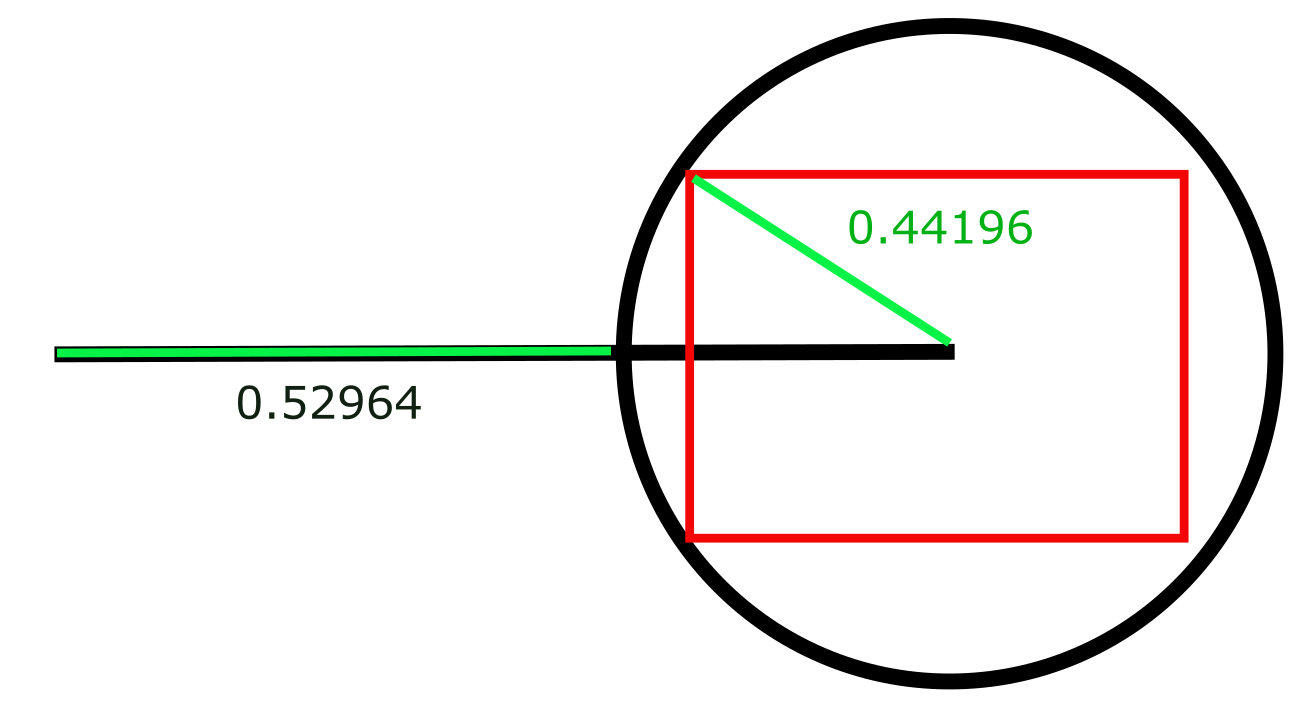

In [22]:
h = 0.25
R_min = 0.9716 - jnp.sqrt(0.44196**2 - h**2)
R_max = 0.9716 + jnp.sqrt(0.44196**2 - h**2)
R = jnp.linspace(R_min, R_max, 100)
Z = jnp.linspace(-h, h, 50)
phi = jnp.linspace(0, jnp.pi/10, 10)
coil_grid = LinearGrid(N=50)
spline = SplineMagneticField.from_field(
    default_coils, R, phi, Z, method="cubic", source_grid=coil_grid
)

In [23]:
spline.save("hbt_default_coils_spline.h5")